No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


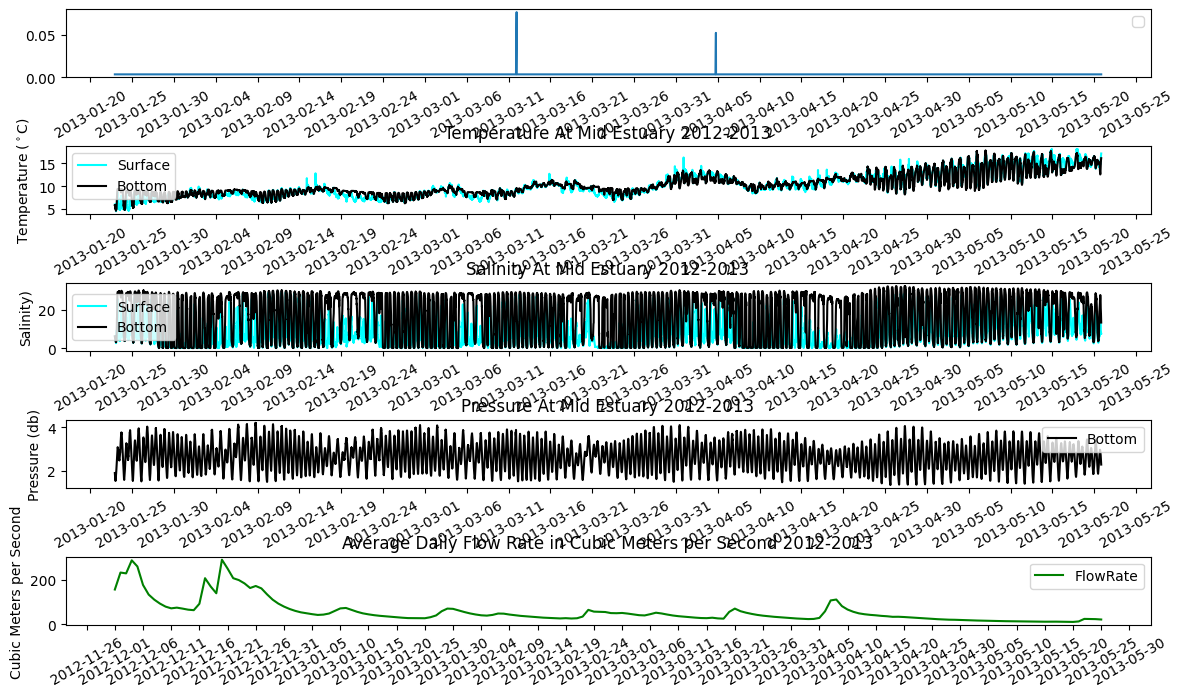

In [10]:
import pandas as pd
import scipy.io as sio
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

#import downriver bottom data
matDataMid = sio.loadmat('2012-13\\hobo_PrivateDock_01.mat')

#mat lab date origin
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')

matDataMidFiltered = {dictKey:dictValue for dictKey, dictValue in matDataMid.items() if dictKey[0] != '_'}
matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})

# create numpy array that contains time 
matMidTimeArray = np.concatenate((matMidDF['DN'][0],matMidDF['DN'][1],matMidDF['DN'][2]))
matMidSurfaceSalinityArray = np.concatenate((matMidDF['SS'][0], matMidDF['SS'][1], matMidDF['SS'][2]))
matMidBottomSalinityArray = np.concatenate((matMidDF['SB'][0], matMidDF['SB'][1], matMidDF['SB'][2]))
matMidBottomPressureArray = np.concatenate((matMidDF['BP'][0], matMidDF['BP'][1], matMidDF['BP'][2]))
matMidBottomTemperatureArray = np.concatenate((matMidDF['TB'][0], matMidDF['TB'][1], matMidDF['TB'][2]))
matMidSurfaceTemperatureArray = np.concatenate((matMidDF['TS'][0], matMidDF['TS'][1], matMidDF['TS'][2]))

matMidFlatDF = pd.DataFrame({'DN' : matMidTimeArray.flatten(), 'SS' : matMidSurfaceSalinityArray.flatten(), 'SB' : matMidBottomSalinityArray.flatten(), 'BP' : matMidBottomPressureArray.flatten(), 'TB' : matMidBottomTemperatureArray.flatten(), 'TS' : matMidSurfaceTemperatureArray.flatten()})
tmsMidriver = matMidFlatDF['DN'] * np.timedelta64(1, 'D') + origin


#reading in flow data
flowDF = pd.read_csv('2012_2013alsea.csv')
flowDF['fRate'] = flowDF['max_va'] * 0.0283168
#create a new column for flow dates
for index, row in flowDF.iterrows():
    calcDate = pd.Timestamp(year=int(row['begin_yr']), month=int(row['month_nu']), day=int(row['day_nu']))
    flowDF.loc[index, 'DN'] = calcDate

tmsFlow = flowDF['DN']

#create the subplots
fig, (axtime, axtemp, axsal,axro, axflow) = plt.subplots(5,figsize=(14, 8))

#set the titles for the plots
axtemp.set_title("Temperature At Mid Estuary 2012-2013")
axsal.set_title("Salinity At Mid Estuary 2012-2013")
axro.set_title("Pressure At Mid Estuary 2012-2013")
axflow.set_title("Average Daily Flow Rate in Cubic Meters per Second 2012-2013")

#set up the y axis for each plot
plt.setp(axtemp, ylabel = "Temperature ($^\circ$C)")
plt.setp(axsal, ylabel = "Salinity)")
plt.setp(axro, ylabel = "Pressure (db)")
plt.setp(axflow, ylabel = "Cubic Meters per Second")

#plot the data on the proper plot
axtime.plot(tmsMidriver,matMidFlatDF['DN'].diff())
axtemp.plot(tmsMidriver, matMidFlatDF['TS'], color = 'cyan', label='Surface')
axtemp.plot(tmsMidriver, matMidFlatDF['TB'], color = 'black', label='Bottom')
axsal.plot(tmsMidriver,matMidFlatDF['SS'],color = 'cyan', label = "Surface")
axsal.plot(tmsMidriver,matMidFlatDF['SB'],color = 'black', label = "Bottom")
axro.plot(tmsMidriver, matMidFlatDF['BP'], color = 'black', label = "Bottom")
axflow.plot(tmsFlow,flowDF['fRate'], color = 'green', label = 'FlowRate')


# Change the tick interval
axtime.xaxis.set_major_locator(mdates.DayLocator(interval=5)) 
axtemp.xaxis.set_major_locator(mdates.DayLocator(interval=5)) 
axsal.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axro.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axflow.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Puts x-axis labels on an angle
axtime.xaxis.set_tick_params(rotation = 30)
axtemp.xaxis.set_tick_params(rotation = 30)  
axsal.xaxis.set_tick_params(rotation = 30)
axro.xaxis.set_tick_params(rotation = 30)
axflow.xaxis.set_tick_params(rotation = 30)

#adjust space between the plots
plt.subplots_adjust(hspace=1)

axtime.legend()
axtemp.legend() 
axsal.legend()
axro.legend()
axflow.legend()
plt.show()

